DC Resistivity Forward Modeling: 1D Sounding
=======================================

In this notebook, we predict data for a Schlumberger sounding survey over a layered Earth.

Import Modules
----------------------

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh

from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.StaticUtils import plot_layer

User Defined Parameters for the Notebook
---------------------------------------------------------------

Here, the user defines the parameters required to run the notebook. The parameters are as follows:

- **half_AB_separation:** a numpy array containing the AB/2 values for the source electrodes
- **half_MN_separations:** a numpy array containing the MN/2 values for the receiver electrodes
- **layer_thicknesses:** Layer thicknesses in meters. Defined from top layer to bottom
- **resistivity_model:** Electrical resistivity for each layer in Ohm-meters


In [7]:
# Make a numpy array for AB/2 values
half_AB_separation = np.r_[
    5,10,20,30,40,40,50,60,70,80,90,100,100,120,140,160,180,200,200,220,240,260,280,300,300,320,350,370,400
]  # AB/2 values

# Make a numpy array for MN/s values
half_MN_separation = np.r_[
    1,1,1,1,1,5,5,5,5,5,5,5,10,10,10,10,10,10,20,20,20,20,20,20,30,30,30,30,30
]  # MN/2 values

# Defining the layer thicknesses
layer_thicknesses = np.r_[20., 10., 20.]

# Define model. A resistivity (Ohm meters) for each layer.
resistivity_model = np.r_[1e3, 1e2, 2e3]

Define the Survey
-------------------------

This portion of the notebook defines a Schlumberger sounding survey using the AB/2 and MN/2 values provided.

In [8]:
source_list = []  # create empty array for sources to live

for ii in range(0, len(half_AB_separation)):
    
    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-half_AB_separation[ii], 0., 0.]
    B_location = np.r_[half_AB_separation[ii], 0., 0.]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-half_MN_separation[ii], 0., 0.]
    N_location = np.r_[half_MN_separation[ii], 0., 0.]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
            M_location, N_location
            )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list.append(
            dc.sources.Dipole(receiver_list, A_location, B_location)
            )

# Define survey
survey = dc.Survey(source_list)

Define a 1D Layered Earth (1D Tensor Mesh)
--------------------------------------------

This part of the notebook creates a layered Earth on which to compuate the forward simulation. To do this, we use
the TensorMesh class. Once created, we can plot the resistivity model on our 1D Earth.

(50.0, 4000.0)

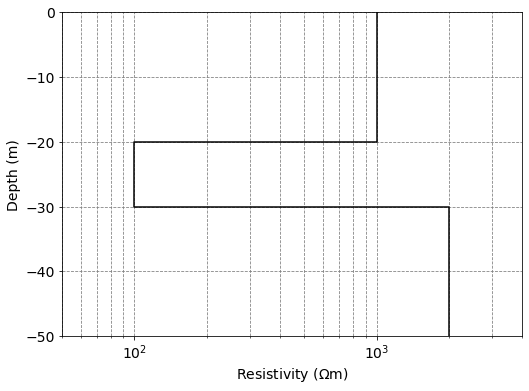

In [9]:
# Define a layered Earth
mesh = TensorMesh([layer_thicknesses])

# Define mapping from model to active cells. Here, all layers are use in the
# forward simulation.
model_map = maps.IdentityMap(mesh)

# Plot the 1D model
fig = plt.figure(figsize=(8, 5))
mpl.rcParams.update({'font.size': 14})
x_min = np.min(model_map*resistivity_model)
x_max = np.max(model_map*resistivity_model)

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
plt.grid(True, which="both", ls="--", c='gray')
plot_layer(model_map*resistivity_model, mesh, ax=ax1, depth_axis=False)
ax1.set_xlim(0.5*x_min, 2*x_max)

Define the Forward Simulation and Predict DC Resistivity Data
-------------------------------------------------------------

In this part of the notebook, all the pieces needed to predict the data are assembled into a *simulation*. Once created, we can predict data for a given *resistivity model*. We have chosen to predicte the data in terms of apparent resistivity, as opposed to raw voltage. Once the data are predicted, we plot the Schlumberger sounding curve.

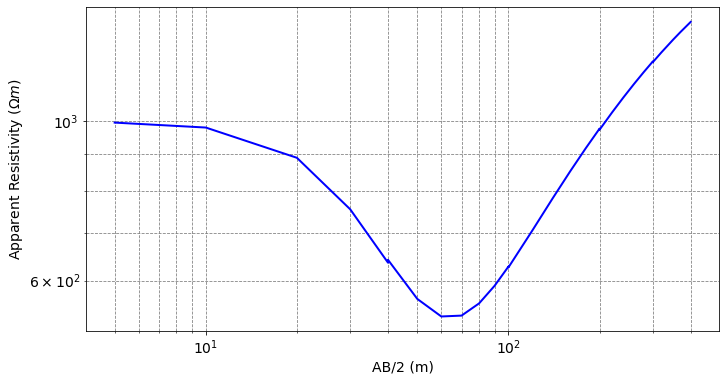

In [10]:
# Create a simulation object
simulation = dc.simulation_1d.DCSimulation_1D(
        mesh, survey=survey, rhoMap=model_map, t=layer_thicknesses,
        data_type="apparent_resistivity"
        )

# Predict data for a given model
dpred = simulation.dpred(resistivity_model)

# Plot apparent resistivities on sounding curve
mpl.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
ax1.loglog(half_AB_separation, dpred, 'b', lw=2)
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel("Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="--", c='gray')
plt.show()